<a href="https://colab.research.google.com/github/dcmoura/spyql/blob/master/notebooks/json_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The fastest command-line tools for querying large JSON datasets

Benchmark with several command-line tools with focus on querying large files that fit into the disk of a standard machine but might not fit into memory.

## Dataset
A subset of the [Amazon book reviews dataset](http://deepyeti.ucsd.edu/jianmo/amazon/) with 10 GB. 

## Benchmarking challenges

*   **Map**: a new column is calculated for all rows (both input and output are large)
*   **Aggregation**/Reduce: the average of all rows of a column is calculated (only the input is large)
*   **Subset**/Filter: the first 100 values of a column matching a search criteria are returned (only a part of the input needs to be processed)

Only tools that support these three operations were included. Notable tools like [fx](https://github.com/antonmedv/fx), [ojg](https://github.com/ohler55/ojg) and [pxi](https://github.com/Yord/pxi) were not included because they do not support aggregations. 

## Test criteria

*   **Processing Time test**: tools fail this test when taking more time than jq (reference) to process 1GB of data, unless the difference is in the order of the tenths of a second. 
*   **Memory Scalability test**: none of the operations in the challenges require having the full dataset loaded into memory. Any tool whose memory consumption is proportional to the size of the input or output fails this test. 


# Results' Summary

*   ClickHouse, OctoSQL, SPyQL, jq and trdsql memory needs are not constrained by the size of the data (although jq queries get more complicated with aggregations).  
*   ClickHouse and OctoSQL were clearly the fastest, processing 6x to 9x more data per second than jq (for 1 GB of input data). SPyQL followed with up to 2x the data processing rate of jq.

Tool | Stars</br>(GitHub) | Processing Time</br>(Map/Aggr/Filter) | Memory Scalability</br>(Map/Aggr/Filter) | Conclusion 
:---|:---:|:---:|:---:|:---
[ClickHouse](https://github.com/ClickHouse/ClickHouse) | [![GitHub stars](https://img.shields.io/github/stars/ClickHouse/ClickHouse?label=)](https://github.com/ClickHouse/ClickHouse) | 👍 👍 👍 | 👍 👍 👍 | Overall the fastest for large files (>=100MB).
[OctoSQL](https://github.com/cube2222/octosql) | [![GitHub stars](https://img.shields.io/github/stars/cube2222/octosql?label=)](https://github.com/cube2222/octosql) | 👍 👍 👍 | 👍 👍 👍  | Overall the fastest for small files (1-10MB),  head to head with ClickHouse on larger files.
[SPyQL](https://github.com/dcmoura/spyql) | [![GitHub stars](https://img.shields.io/github/stars/dcmoura/spyql?label=)](https://github.com/dcmoura/spyql) | 👍 👍 👍 | 👍 👍 👍 | Up to 2x faster than jq but up to 5x slower than the best (for 1GB of data). 2nd lowest memory footprint (22MB), independently of the input size. 
[jq](https://github.com/stedolan/jq) | [![GitHub stars](https://img.shields.io/github/stars/stedolan/jq?label=)](https://github.com/stedolan/jq) | _reference_ | 👍 👍 👍 | The lowest memory footprint (6MB) if you can avoid building arrays in memory. 
[Miller](https://github.com/johnkerl/miller) | [![GitHub stars](https://img.shields.io/github/stars/johnkerl/miller?label=)](https://github.com/johnkerl/miller) | 👍 👍 ❌ | ❌ ❌ ❌ | Comparable or faster performance than jq. Memory grows with the size of input data => always reads the full dataset into memory. 
[trdsql](https://github.com/noborus/trdsql) | [![GitHub stars](https://img.shields.io/github/stars/noborus/trdsql?label=)](https://github.com/noborus/trdsql) | ❌ ❌ ❌ | 👍 👍 👍 | Among the slowest but always with a low memory footprint (29MB). Always processes the full dataset.
[spark-sql CLI](https://github.com/apache/spark) | [![GitHub stars](https://img.shields.io/github/stars/apache/spark?label=)](https://github.com/apache/spark) | ❌ ❌ ❌ | ❌ 👍 👍 | Large overhead, catching-up on GB-sized data, but always among the slowest. Always processes the full dataset. Output size does not scale (full output is written to the driver's memory in the CLI's implementation).
[DSQ](https://github.com/multiprocessio/dsq) | [![GitHub stars](https://img.shields.io/github/stars/multiprocessio/dsq?label=)](https://github.com/multiprocessio/dsq) | ❌ ❌ ❌ | ❌ ❌ ❌ | Among the slowest and with a large footprint => always reads the full dataset into memory.


# Limitations

*   Conclusions are limited to the dataset and operations used. Results may differ for different datasets, operations, hardware and operative system;
*   Applications installed using apt-get might not be the latest available versions.

# Feedback

Leave your comments in this [GitHub issue](https://github.com/dcmoura/spyql/issues/72). Thanks! 

-----

*Disclaimer: this benchmark is part of the [SPyQL project](https://github.com/dcmoura/spyql)*

# Setup

In [ ]:
# SETUP
!pip install -q ipython-autotime
%load_ext autotime

!apt -qq update
!apt -qq install -y time
!apt -qq install -y jq

!pip install -q --upgrade "pip>=20.3"
!pip install -q --upgrade orjson
!pip install -q spyql

!add-apt-repository -y ppa:longsleep/golang-backports > /dev/null 2>&1
!apt -qq install -y golang-go 

!go clean -modcache
!go install github.com/multiprocessio/dsq@latest > /dev/null 2>&1
!go install github.com/cube2222/octosql@latest > /dev/null 2>&1
!cp /root/go/bin/* /usr/local/bin
%env OCTOSQL_NO_TELEMETRY=1 

!go install github.com/noborus/trdsql@latest
!cd /root/go/pkg/mod/github.com/noborus/trdsql@v0.9.1/ ; make ; make install
!cp /root/go/pkg/mod/github.com/noborus/trdsql@v0.9.1/trdsql /usr/local/bin

!apt-get install miller

!wget https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar -xzf spark-3.2.1-bin-hadoop2.7.tgz
!mv spark-3.2.1-bin-hadoop2.7 spark

!apt-get -qq install -y apt-transport-https ca-certificates dirmngr
!apt-key adv --keyserver hkp://keyserver.ubuntu.com:80 --recv 8919F6BD2B48D754
!echo "deb https://packages.clickhouse.com/deb stable main" | tee /etc/apt/sources.list.d/clickhouse.list
!apt-get -qq update
!apt-get -qq install -y clickhouse-common-static
%env LD_PRELOAD=

In [2]:
# VERSIONS
!lsb_release -a

!python --version
!go version
!java --version

!jq --version
!spyql --version
!dsq --version
!octosql --version
!mlr --version
!trdsql --version
!spark/bin/spark-sql --version
!clickhouse local --version

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
Python 3.7.13
go version go1.18.1 linux/amd64
openjdk 11.0.14.1 2022-02-08
OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
jq-1.5-1-a5b5cbe
spyql, version 0.6.0
dsq latest
octosql version dev
Miller 5.3.0
trdsql version devel
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.1
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 11.0.14.1
Branch HEAD
Compiled by user hgao on 2022-01-20T20:15:47Z
Revision 4f25b3f71238a00508a356591553f2dfa89f8290
Url https://github.com/apache/spark
Type --help for more information.
ClickHouse local version 22.3.3.44 (official build).
time: 4.85 s (started: 2022-04-19 12:00:31 +00:00)


In [3]:
#download dataset
!curl -s -N http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz | gunzip --stdout | head -11675000 > books.json
!ls -lh books.json

-rw-r--r-- 1 root root 9.4G Apr 19 12:02 books.json
time: 2min 5s (started: 2022-04-19 12:00:36 +00:00)


# Benchmark

In [4]:
#Create empty log files and a benchmarking script

#Execution time, memory peak, exit code, and command executed:
!> performance.log
#Size of the sample file:
!> sample_size.log
#Challenge being addressed:
!> challenge.log

#Benchmarking script
!echo 'echo "Running: $@"' > bench.sh
!echo '/usr/bin/time -o performance.log -a -f"%e\t%M\t%x\t%C" "$@" > /dev/null 2>&1' >> bench.sh
!echo 'mv sample_size.log sample_size.old; cat sample_size.old sample_size.this >> sample_size.log' >> bench.sh
!echo 'mv challenge.log challenge.old; cat challenge.old challenge.this >> challenge.log' >> bench.sh
!echo 'tail -1 performance.log' >> bench.sh
!chmod +x bench.sh

time: 941 ms (started: 2022-04-19 12:02:41 +00:00)


In [5]:
for i in range(3,11):
  n_bytes = 10**i
  print(f"---- RUN {i} ----")
  !echo "Bytes: $n_bytes"
  n_lines = !head -c "$n_bytes" books.json | wc -l
  n_lines = int(n_lines[0]) + 1 
  !echo "Lines: $n_lines"
  !head -n "$n_lines" books.json > sample.json
  !wc sample.json > sample_size.this
  !cat sample_size.this

  !echo "Aggregation" > challenge.this #average of the overall score for the full sample (REDUCE)
  !cat challenge.this
  if i <= 9:
    # utils that do not scale (memory)
    !./bench.sh mlr --ijson stats1 -a mean -f overall sample.json
    !./bench.sh dsq -s jsonl "SELECT AVG(overall) FROM {}" < sample.json

  !./bench.sh octosql --output json "SELECT AVG(overall) FROM sample.json"
  !./bench.sh jq -n '[inputs.overall] | add/length' sample.json
  !./bench.sh jq -n 'def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .overall) | .[0] / .[1]' sample.json
  !./bench.sh spyql "SELECT avg_agg(json->overall) FROM orjson" < sample.json
  !./bench.sh trdsql "SELECT avg(overall) FROM sample.json"
  !./bench.sh clickhouse local --input_format_max_rows_to_read_for_schema_inference=200 -q "SELECT AVG(overall) FROM file(sample.json, JSONEachRow)"
  !./bench.sh spark/bin/spark-sql --driver-memory 4g --executor-memory 2g -e "SELECT avg(overall) FROM json.\`sample.json\`" 

  !echo "Map" > challenge.this # name, date and normalized score (MAP)
  !cat challenge.this
  if i <= 9:
    # utils that do not scale (memory)
    !./bench.sh mlr --ijson put '$score = $overall/5.0' then cut -f reviewerName,reviewTime,score then rename reviewerName,name,reviewTime,date sample.json
    !./bench.sh dsq -s jsonl "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM {}" < sample.json
    
  !./bench.sh octosql --output json "SELECT reviewerName as name, reviewTime as date, /(overall,5.0) as score FROM sample.json"
  !./bench.sh jq -c '.score = .overall/5.0 | {name: .reviewerName, date: .reviewerTime, score: .score}' sample.json
  !./bench.sh spyql "SELECT json->reviewerName as name, json->reviewTime as date, json->overall/5.0 as score FROM orjson" < sample.json
  !./bench.sh trdsql "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM sample.json"
  !./bench.sh clickhouse local --input_format_max_rows_to_read_for_schema_inference=200 -q "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM file(sample.json, JSONEachRow)"
  !./bench.sh spark/bin/spark-sql --driver-memory 8g --executor-memory 1g -e "SELECT reviewerName as name, reviewTime as date, overall/5.0 as score FROM json.\`sample.json\`"  

  !echo "Subset" > challenge.this # any 100 reviewTexts with overall score of 4 (FILTER)
  !cat challenge.this
  if i<=9:
    !./bench.sh mlr --ijson filter '$overall == 4' then cut -f reviewText then head -n 100 sample.json
    !./bench.sh dsq -s jsonl "SELECT reviewText FROM {} WHERE overall = 4.0 LIMIT 100" < sample.json

  !./bench.sh octosql --output json "SELECT reviewText FROM sample.json WHERE overall=4.0 LIMIT 100"
  !./bench.sh bash -c "jq 'select(.overall==4) | .reviewText' sample.json | jq -n 'limit(100;inputs)'"
  !./bench.sh spyql "SELECT json->reviewText FROM orjson WHERE json->overall==4 LIMIT 100" < sample.json
  !./bench.sh trdsql "SELECT reviewText FROM sample.json WHERE overall=4.0 LIMIT 100"
  !./bench.sh clickhouse local --input_format_max_rows_to_read_for_schema_inference=200 -q "SELECT reviewText FROM file(sample.json, JSONEachRow) WHERE overall=4.0 LIMIT 100"
  !./bench.sh spark/bin/spark-sql --driver-memory 4g --executor-memory 2g -e "SELECT reviewText FROM json.\`sample.json\` WHERE overall=4 LIMIT 100"     

---- RUN 3 ----
Bytes: 1000
Lines: 1
   1  191 1174 sample.json
Aggregation
Running: mlr --ijson stats1 -a mean -f overall sample.json
0.02	2852	0	mlr --ijson stats1 -a mean -f overall sample.json
Running: dsq -s jsonl SELECT AVG(overall) FROM {}
0.39	37476	0	dsq -s jsonl SELECT AVG(overall) FROM {}
Running: octosql --output json SELECT AVG(overall) FROM sample.json
0.13	14752	0	octosql --output json SELECT AVG(overall) FROM sample.json
Running: jq -n [inputs.overall] | add/length sample.json
0.01	2740	0	jq -n [inputs.overall] | add/length sample.json
Running: jq -n def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .overall) | .[0] / .[1] sample.json
0.00	2568	0	jq -n def sigma(s): reduce s as $x([0,0]; [.[0]+$x, .[1]+1]); sigma(inputs | .overall) | .[0] / .[1] sample.json
Running: spyql SELECT avg_agg(json->overall) FROM orjson
0.32	17928	0	spyql SELECT avg_agg(json->overall) FROM orjson
Running: trdsql SELECT avg(overall) FROM sample.json
0.08	9456	0	trdsql SELEC

In [6]:
!sed 's/\s\+/\t/g' sample_size.log | sed 's/^\t*//g' > size.log
!paste size.log challenge.log performance.log > all.log

time: 231 ms (started: 2022-04-19 13:13:12 +00:00)


In [7]:
from google.colab import files, data_table
files.download('all.log')
files.download('performance.log')
data_table.enable_dataframe_formatter()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 20.5 ms (started: 2022-04-19 13:13:12 +00:00)


# Analysis

In [8]:
import pandas as pd
from math import *

df = pd.read_csv('all.log', delimiter = '\t', names = [
  'n_recs', 'n_words', 'bytes', 'fname', 'challenge', 'proc_time', 'memory', 'exit_code', 'cmd'
])
df['Memory Peak (MB)'] = df['memory']//1000
df['Processing Time (s)'] = df['proc_time']
df['Command'] = df['cmd']
df['Processing Rate (MB/s)'] = round(df['bytes'] * 1e-6 / df['proc_time'],1)
df['om'] = [round(log10(x)) for x in df['bytes'] ]
df['Tool'] = df['cmd'].str.replace('python3 -c import ', '').str.replace('spark/bin/', '').str.replace('bash -c ', '').str.split().str[0]
df["Variant"] = ''
df.loc[(df['Tool']=='jq') & (df['cmd'].str.find('reduce') > 0), "Variant"] = 'jq (reduce)'
df['Input Size (MB)'] = df['bytes']*1e-6

def result_table(challenge, cols = ['Tool', 'Command', 'Processing Time (s)', 'Processing Rate (MB/s)', 'Memory Peak (MB)']):
  print(f"{challenge} challenge: results for 1GB of input data") 
  sub_df = df[(df['challenge']==challenge) & (df['om']==9)][cols].sort_values(by = ['Processing Time (s)']) #.reset_index(drop=True)
  sub_df['Rank'] = range(1, len(sub_df)+1)
  return sub_df.set_index('Rank')

def result_plot(challenge, cols = ["Processing Time (s)", "Memory Peak (MB)"]):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mticker
  import seaborn as sns
  import numpy as np

  data = df[(df["Input Size (MB)"] >= 1) & (df['challenge']==challenge)]
  extra_opts = {} if len(data["Variant"].value_counts()) == 1 else {"style": "Variant"}
  fig, axs = plt.subplots(1,len(cols), figsize=(16,6))
  fig.set_dpi(100)
  fig.suptitle(f"{challenge} challenge")
  plt.subplots_adjust(wspace=0.3)
  for i,col in enumerate(cols):
    ax = axs[i]
    sns.lineplot(x="Input Size (MB)", y=col,
                hue="Tool",               
                marker = "o",
                data=data,
                ax = ax,
                **extra_opts)
    ax.legend(loc= 'best')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(x, ',.2f').rstrip('0').rstrip('.')))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(x, ',.2f').rstrip('0').rstrip('.')))
    ax.grid(which='minor', linestyle=':', linewidth=0.5)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.set_title(f"{col} vs Input Size (MB)")
  plt.show()

time: 1.61 s (started: 2022-04-19 13:13:12 +00:00)


# Map challenge

Name, date and normalized score for all reviews, while renaming properties' names

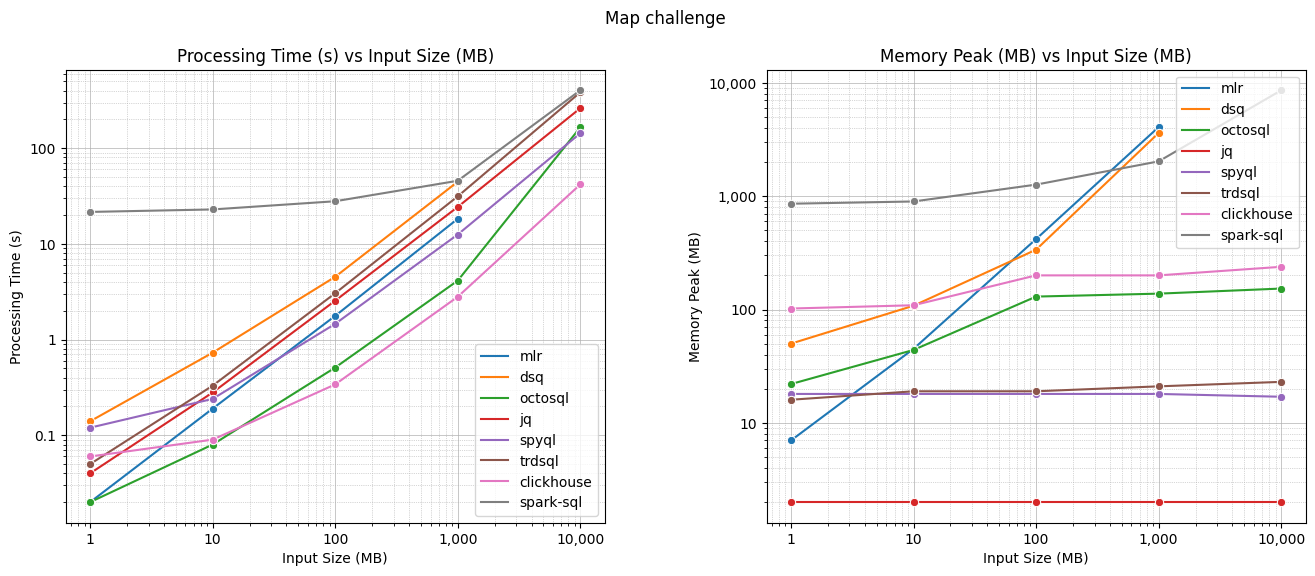

In [9]:
result_plot("Map")

In [10]:
result_table('Map')

time: 2.81 s (started: 2022-04-19 13:13:14 +00:00)
Map challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Processing Rate (MB/s),Memory Peak (MB)
Rank,,,,,
1,clickhouse,clickhouse local --input_format_max_rows_to_re...,2.80,357.1,200
2,octosql,octosql --output json SELECT reviewerName as n...,4.13,242.1,138
3,spyql,"spyql SELECT json->reviewerName as name, json-...",12.53,79.8,18
4,mlr,mlr --ijson put $score = $overall/5.0 then cut...,18.28,54.7,4063
5,jq,jq -c .score = .overall/5.0 | {name: .reviewer...,24.33,41.1,2
6,trdsql,"trdsql SELECT reviewerName as name, reviewTime...",31.38,31.9,21
7,dsq,"dsq -s jsonl SELECT reviewerName as name, revi...",44.63,22.4,3602
8,spark-sql,spark/bin/spark-sql --driver-memory 8g --execu...,45.68,21.9,2025


time: 48.6 ms (started: 2022-04-19 13:13:17 +00:00)


# Aggregation (reduce) challenge

Average overall score from all reviews

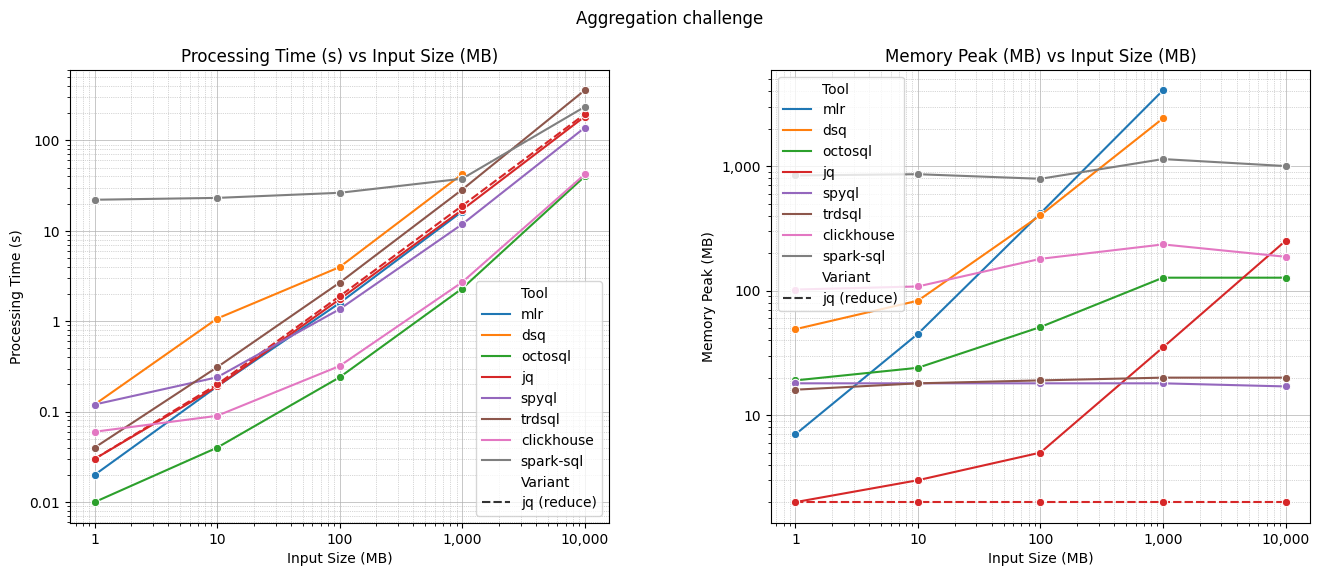

time: 1.77 s (started: 2022-04-19 13:13:17 +00:00)


In [11]:
result_plot("Aggregation")

In [12]:
result_table('Aggregation')

Aggregation challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Processing Rate (MB/s),Memory Peak (MB)
Rank,,,,,
1,octosql,octosql --output json SELECT AVG(overall) FROM...,2.30,434.8,127
2,clickhouse,clickhouse local --input_format_max_rows_to_re...,2.70,370.4,235
3,spyql,spyql SELECT avg_agg(json->overall) FROM orjson,11.81,84.7,18
4,mlr,mlr --ijson stats1 -a mean -f overall sample.json,16.35,61.2,4063
5,jq,jq -n [inputs.overall] | add/length sample.json,17.05,58.7,35
6,jq,"jq -n def sigma(s): reduce s as $x([0,0]; [.[0...",18.91,52.9,2
7,trdsql,trdsql SELECT avg(overall) FROM sample.json,28.53,35.1,20
8,spark-sql,spark/bin/spark-sql --driver-memory 4g --execu...,37.67,26.5,1139
9,dsq,dsq -s jsonl SELECT AVG(overall) FROM {},42.29,23.6,2419


time: 29.5 ms (started: 2022-04-19 13:13:19 +00:00)


# Subset (filter) challenge

Texts of any 100 reviews with overall score of 4

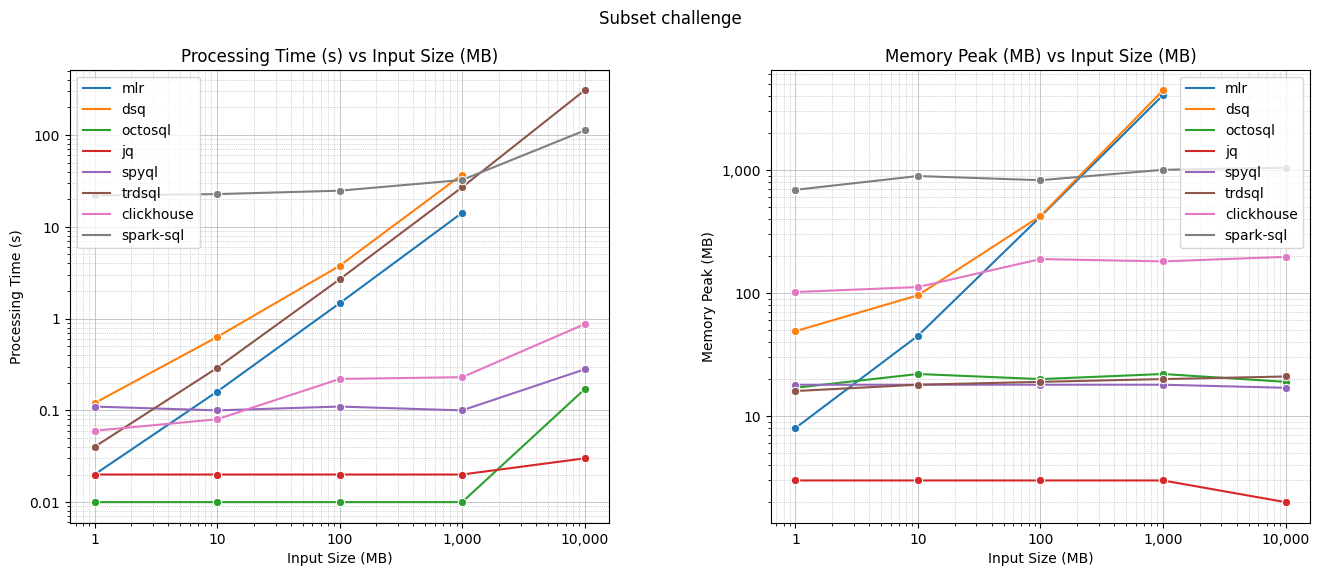

time: 1.81 s (started: 2022-04-19 13:13:19 +00:00)


In [13]:
result_plot("Subset")

In [14]:
result_table('Subset', ['Tool', 'Command', 'Processing Time (s)', 'Memory Peak (MB)'])

Subset challenge: results for 1GB of input data


,Tool,Command,Processing Time (s),Memory Peak (MB)
Rank,,,,
1,octosql,octosql --output json SELECT reviewText FROM s...,0.01,22
2,jq,bash -c jq 'select(.overall==4) | .reviewText'...,0.02,3
3,spyql,spyql SELECT json->reviewText FROM orjson WHER...,0.10,18
4,clickhouse,clickhouse local --input_format_max_rows_to_re...,0.23,181
5,mlr,mlr --ijson filter $overall == 4 then cut -f r...,14.22,4063
6,trdsql,trdsql SELECT reviewText FROM sample.json WHER...,27.02,20
7,spark-sql,spark/bin/spark-sql --driver-memory 4g --execu...,32.43,1005
8,dsq,dsq -s jsonl SELECT reviewText FROM {} WHERE o...,37.11,4448


time: 27.2 ms (started: 2022-04-19 13:13:20 +00:00)
